# importing important librarys 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Embedding,Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import re
from tensorflow.keras.layers import Bidirectional
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
data=pd.read_csv('intent1-corrected.csv',names=['Text','Intent'],encoding="utf-8")
data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(10561, 2)


,Text,Intent
0,Kiyyoo dirama oso eguti jirun na darbe tari a...,Question
1,Meeti ree kuta 28ffaa,Question
2,Kutaa digdami sadetaffa isiin egee dadhabee.,Negative
3,Kutaa digdami sadetaffaa fiidagaa maali nuuraa...,Negative
4,Nuuf jabbadhakaa warii Akka kotti kiyyoo jaala...,Positive


<AxesSubplot:xlabel='Intent', ylabel='count'>

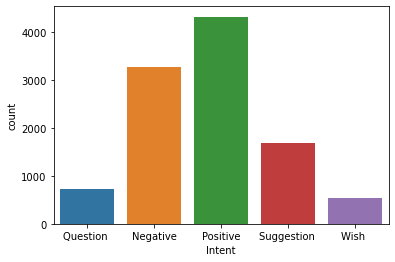

In [3]:
sns.countplot(x='Intent', data=data)

In [4]:
data["Intent"].value_counts()
#print(len('Gosa_miira'))
#print(len('jechoota'))

Positive       4320
Negative       3271
Suggestion     1686
Question        736
Wish            546
Name: Intent, dtype: int64

# data preprocessing  

In [5]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sen.lower()
    sentence = re.sub(r'wo*w','wow', sentence)
    sentence = re.sub(r'uu*f','uff', sentence)
    return sentence
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(Text):
    return TAG_RE.sub('', Text)

In [6]:
def remove_stopwords(review_words):
    with open('stopwords.txt')as stopfile:
        stopwords=stopfile.read()
        list=stopwords.split()
        print(list)
        with open("intent1.csv") as workfile:
            read_data=workfile.read()
            data=read_data.split()
            print(data)
            for word1 in list:
                for word2 in data:
                    if word1==word2:
                        return data.remove(list)
                        print(remove_stopwords)

In [7]:
data['Text'].apply(lambda x: x.lower())

0        kiyyoo dirama oso  eguti jirun na darbe tari a...
1                                    meeti ree kuta 28ffaa
2             kutaa digdami sadetaffa isiin egee dadhabee.
3        kutaa digdami sadetaffaa fiidagaa maali nuuraa...
4        nuuf jabbadhakaa warii akka kotti kiyyoo jaala...
                               ...                        
10556    isheenis namoota dogoggoraa waliin lafa dogogg...
10557    vidiyichis battalumatti qoodamuun marsariitiiw...
10558    gochiwwan qaamaa warraabbicha irratti ture bah...
10559              jechi gurbbichaa altokkicha dhagahame. 
10560                           viidiyoo waraabaa jirtaa? 
Name: Text, Length: 10561, dtype: object

# Feature Extraction

In [8]:
tokenizer=Tokenizer(num_words=4000,split=" ")
tokenizer.fit_on_texts(data['Text'].values)
x=tokenizer.texts_to_sequences(data['Text'].values)
x=pad_sequences(x)
x[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  200, 3022, 3023,   37,  193,  140,  325],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  439, 3332],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  162, 3333,  326,  423],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  162, 3333,  157, 3113,   47],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

In [9]:
model = Sequential()
model.add(Embedding(4000, 128, input_length=x.shape[1]))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(300, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(Bidirectional(LSTM(250, dropout=0.3, recurrent_dropout=0.2)))
#model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.3))
model.add(Dense(5, activation = 'softmax'))

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [11]:
y=pd.get_dummies(data['Intent']).values
[print(data['Intent'][i],y[i]) for i in range(0,5)]

Question  [0 0 1 0 0]
Question  [0 0 1 0 0]
Negative [1 0 0 0 0]
Negative [1 0 0 0 0]
Positive [0 1 0 0 0]


[None, None, None, None, None]

# Training and Testing dataset Splitting 

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

# Train the Model

In [14]:
batch_size = 512
epochs = 15
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, y_test), verbose=2)

Epoch 1/15
17/17 - 128s - loss: 1.3955 - accuracy: 0.3879 - val_loss: 1.3519 - val_accuracy: 0.4051 - 128s/epoch - 8s/step
Epoch 2/15
17/17 - 139s - loss: 1.3068 - accuracy: 0.4712 - val_loss: 1.0791 - val_accuracy: 0.5845 - 139s/epoch - 8s/step
Epoch 3/15
17/17 - 167s - loss: 1.0576 - accuracy: 0.6070 - val_loss: 0.8390 - val_accuracy: 0.7014 - 167s/epoch - 10s/step
Epoch 4/15
17/17 - 173s - loss: 0.7052 - accuracy: 0.7411 - val_loss: 0.7171 - val_accuracy: 0.7345 - 173s/epoch - 10s/step
Epoch 5/15
17/17 - 149s - loss: 0.5504 - accuracy: 0.8031 - val_loss: 0.6033 - val_accuracy: 0.7747 - 149s/epoch - 9s/step
Epoch 6/15
17/17 - 178s - loss: 0.4435 - accuracy: 0.8374 - val_loss: 0.5368 - val_accuracy: 0.7974 - 178s/epoch - 10s/step
Epoch 7/15
17/17 - 185s - loss: 0.3859 - accuracy: 0.8585 - val_loss: 0.5122 - val_accuracy: 0.8097 - 185s/epoch - 11s/step
Epoch 8/15
17/17 - 238s - loss: 0.3507 - accuracy: 0.8659 - val_loss: 0.5004 - val_accuracy: 0.8239 - 238s/epoch - 14s/step
Epoch 9/15


In [16]:
scores = cross_val_score(model, x_test, y_test, scoring = 'r2', cv = 10)

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x000001FA9BCA5310>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

# Test the Model 

In [ ]:
predictions = model.predict(x_test)

In [ ]:
scores = model.evaluate(x_test, y_test,verbose=2)

print(scores)

In [ ]:
model.save("Intent_Classification.h5")

In [ ]:
new_intent = ['Kiyyoo dirama oso  eguti jirun na darbe tari ayaana moo sababa godhatu moyuu']
seq = tokenizer.texts_to_sequences(new_intent)
padded = pad_sequences(seq, maxlen=6000)
pred = model.predict(padded)
Intent = ['Question', 'Negative', 'Positive', 'Suggestion', 'Wish']
print(pred, Intent[np.argmax(pred)])

In [ ]:
[print (data['Text'][i], predictions[i], y_test[i]) for i in range(0, 400)]

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
cm=metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [ ]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [ ]:
print(FP)
print(FN)
print(TP)
print(TN)

In [ ]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = 2*precision*recall/(precision+recall)

In [ ]:
print("precision",precision)
print("recall  ", recall)
print("f1_score",f1_score)

In [ ]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [ ]:
accuracy(cm)